In [1]:
scores = '../out/ko_scores.txt'
complexes = '../out/complexes.cyc2008.txt'
kegg = '../out/modules.kegg.txt'
string = '../out/string.combined.800.txt'
go = '../out/SGD_slim.tsv'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=11)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=11)

In [3]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy.spatial import distance

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
markers = ['.', 'o', 'v',
           '^', '<', '>', '1',
           '2', '3', '4', '8',
           's', 'p', '*', 'h',
           'H', '+', 'D', 'd',
           '|', '_']

In [5]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = [1 if v <= 0.05
                  else 0
                  for v in m['qvalue'].values]
m['signed-qvalue'] = -np.log10(m['qvalue']) * np.sign(m['score'])

In [6]:
strains = sorted({x[0] for x in m.index})

In [7]:
def run_deviations(m, infile, go=False, significance=False):
    cpx = {}
    if not go:
        for l in open(infile):
            c, genes = l.rstrip().split()
            if len(genes.split(',')) > 1:
                cpx[c] = set(genes.split(','))
    else:
        for l in open(infile):
            gene, gos = l.rstrip().split()
            gos = set(gos.split(';'))
            for go in gos:
                cpx[go] = cpx.get(go, set())
                cpx[go].add(gene)
    strains = sorted({x[0] for x in m.index})
    sgenes = {strain: {x[0] for x in m.loc[strain].index}
              for strain in strains}
    agenes = None
    for strain in sgenes:
        if agenes is None:
            agenes = sgenes[strain]
        else:
            agenes = agenes.intersection(sgenes[strain])
    sub_cpx = {}
    for k, v in cpx.items():
        sub_cpx[k] = v.intersection(agenes)
    res = []
    for current_cpx, genes in sub_cpx.items():
        if len(genes) < 3 or len(genes) > 30:
            continue
        r = None
        for strain in strains:
            if not significance:
                r1 = m.loc[strain].loc[sorted(genes), 'score']
            else:
                r1 = m.loc[strain].loc[sorted(genes), 'signed-qvalue']
            r1 = r1[~r1.index.duplicated()].dropna()
            r1.name = strain
            r1.index.name = 'strain'
            if r is None:
                r = r1.to_frame()
            else:
                r = r.join(r1.to_frame())
        r = r.stack()
        r.index.names = ['gene', 'condition', 'strain']
        r = r.reset_index().set_index(['strain', 'gene', 'condition'])[0]
        r = r.sort_index()
        r = r.unstack().T.dropna().T.stack()
        z = r.to_frame().pivot_table(index='gene',
                                     columns=['strain', 'condition'],
                                     values=0)
        w = r.to_frame().pivot_table(index=['strain', 'gene'],
                                     columns='condition',
                                     values=0)
        y = w.T.apply(lambda x: distance.euclidean(x, z[x.name[0]].median()))
        # y = w.T.apply(lambda x: distance.euclidean(x, np.zeros(x.shape[0])))
        for strain, gene, dist in y.reset_index().values:
            res.append((current_cpx, strain, gene, dist))
    r = pd.DataFrame(res,
                     columns=['complex',
                              'strain',
                              'gene',
                              'distance'])
    r = r.set_index(['strain',
                     'complex',
                     'gene']).sort_index()['distance']
    return r

In [8]:
def plot_residues(r):
    plt.figure(figsize=(7, 2.5))

    for i, (strain1, strain2) in enumerate(itertools.combinations(strains, 2)):
        r1 = r.loc[strain1]
        r2 = r.loc[strain2]
        
        sns.kdeplot(r1 - r2,
                    label='%s %s' % (strain1,
                                     strain2),
                    lw=2)
    plt.xlabel('residues')
    plt.yticks([])
    plt.ylabel('')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    plt.legend(frameon=True)
    sns.despine(left=True)

In [9]:
def get_significance(r1, r2):
    values = r1 - r2
    zscore = (values - values.median()) / values.mad()
    pvalues = stats.norm.sf(abs(zscore.as_matrix()))*2
    qvalues = sm.stats.multipletests(pvalues,
                                     method='fdr_bh')[1]
    return qvalues

In [48]:
def get_deviating_complexes(r):
    res = []
    
    for i, (strain1, strain2) in enumerate(itertools.combinations(strains, 2)):
        r1 = r.loc[strain1]
        r2 = r.loc[strain2]
        
        qvals = get_significance(r1, r2)
        
        for (comp, gene), x, y, q in zip(r1.index,
                                         r1.values,
                                         r2.values,
                                         qvals):
            res.append((comp, gene, strain1, strain2,
                        x, y, q))
    return pd.DataFrame(res,
                        columns=['complex',
                                 'gene',
                                 'strain1', 'strain2',
                                 'value1', 'value2',
                                 'qvalue'])

In [10]:
def plot_overall(r):
    plt.figure(figsize=(9, 6))

    for i, (strain1, strain2) in enumerate(itertools.combinations(strains, 2)):
        plt.subplot(2, 3, i+1)

        r1 = r.loc[strain1]
        r2 = r.loc[strain2]
        
        qvals = get_significance(r1, r2)
        
        plt.plot(r1[qvals > 0.05],
                 r2[qvals > 0.05],
                 'ko',
                 alpha=0.3)
        
        plt.plot(r1[qvals <= 0.05],
                 r2[qvals <= 0.05],
                 'ro',
                 alpha=0.3)

        plt.xlabel(strain1)
        plt.ylabel(strain2)

        plt.xlim(0, r.max()+1)
        plt.ylim(0, r.max()+1)

        plt.plot([0, r.max()+1],
                 [0, r.max()+1],
                 '--',
                 color='grey')

    plt.tight_layout();

In [11]:
def plot_single(r, sub_cpx):
    plt.figure(figsize=(9, 6))

    x = r.loc[slice(None), sub_cpx].to_frame()
    x['qvalue'] = np.empty(x.shape[0])
    
    for i, (strain1, strain2) in enumerate(itertools.combinations(strains, 2)):
        plt.subplot(2, 3, i+1)
        
        r1 = r.loc[strain1]
        r2 = r.loc[strain2]
        
        qvals = get_significance(r1, r2)

        r1 = r1.to_frame()
        r1['qvalue'] = qvals
        r2 = r2.to_frame()
        r2['qvalue'] = qvals
        
        x1 = r1.loc[sub_cpx]
        x2 = r2.loc[sub_cpx]
        
        for marker, (j, gene) in zip(markers,
                                     enumerate({x for x in x1.index})):
            if x1.loc[gene, 'qvalue'] > 0.05:
                color = 'k'
            else:
                color = 'r'
            plt.plot(x1.loc[gene, 'distance'],
                     x2.loc[gene, 'distance'],
                     color=color,
                     marker=marker,
                     markersize=10,
                     alpha=0.5)

        plt.xlim(0, r.max()+1)
        plt.ylim(0, r.max()+1)

        plt.plot([0, r.max()+1],
                 [0, r.max()+1],
                 '--',
                 color='grey')

        plt.xlabel(strain1)
        plt.ylabel(strain2)

    plt.tight_layout();

Protein complexes
---

In [49]:
r = run_deviations(m, complexes)

In [61]:
z = get_deviating_complexes(r)
w = z.groupby(['complex', 'gene']).min()
w[w <= 0.05]['qvalue'].dropna().sort_values()

complex  gene   
SLM      YNL047C    3.380586e-07
SDH      YKL148C    2.937841e-04
CLN      YAL040C    6.152588e-04
VPS7     YDR485C    1.885091e-03
SNF      YGL115W    3.672044e-03
GIM      YNL153C    6.817501e-03
SDH      YLL041C    6.824764e-03
SWC      YBR231C    7.147340e-03
RAD2     YER173W    7.147340e-03
VPS7     YNL246W    7.537710e-03
RAD2     YJR035W    9.607220e-03
BRE      YNR051C    1.747783e-02
DUG      YNL191W    1.816060e-02
OST      YDL232W    2.736329e-02
SNF      YHL025W    2.736329e-02
PMT      YAL023C    2.898793e-02
RAD      YER162C    4.440508e-02
Name: qvalue, dtype: float64

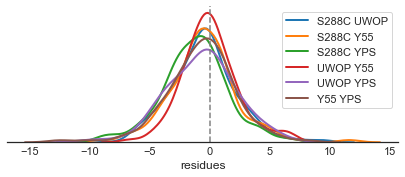

In [13]:
plot_residues(r)

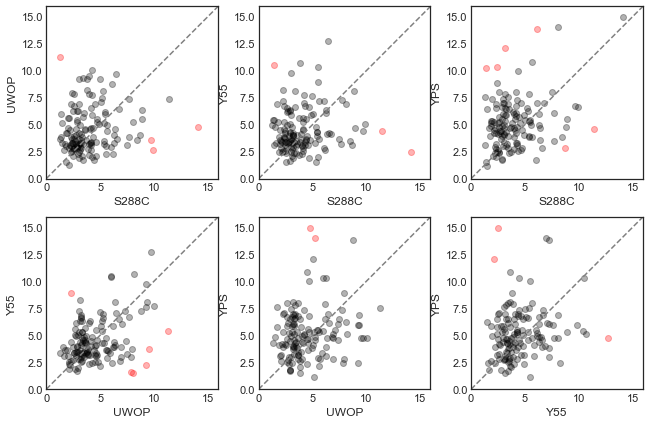

In [14]:
plot_overall(r)

In [15]:
r.groupby('complex').mad().sort_values(ascending=False).head()

complex
SLM     3.069480
VPS7    2.920615
SNF     2.688525
SDH     2.274171
BRE     2.261255
Name: distance, dtype: float64

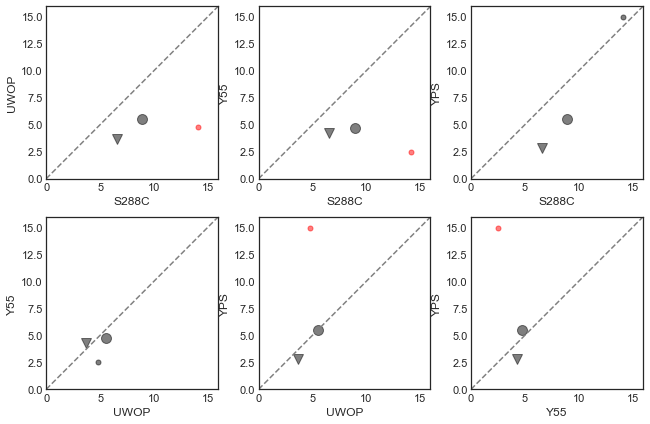

In [16]:
plot_single(r, 'SLM')

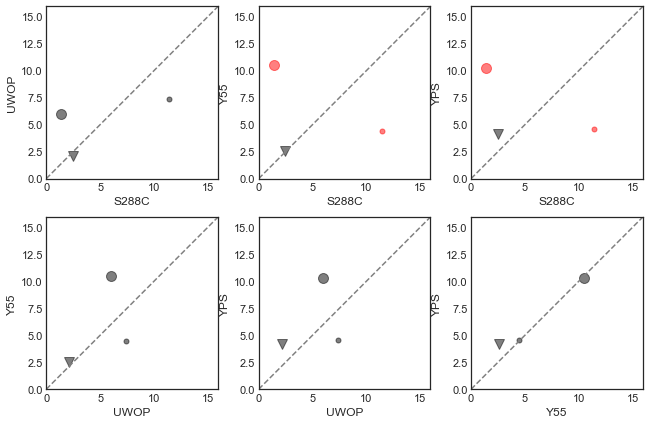

In [17]:
plot_single(r, 'VPS7')

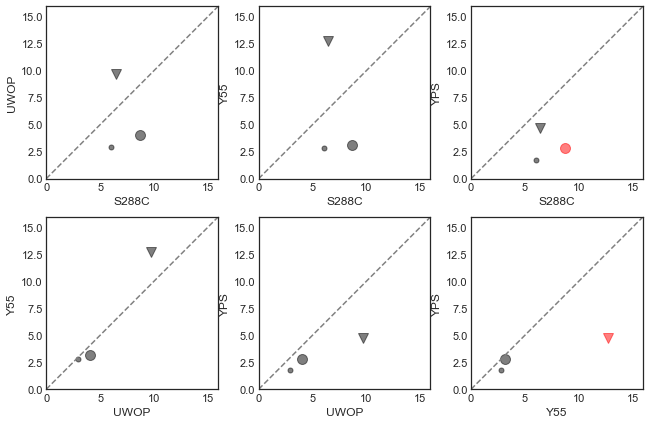

In [18]:
plot_single(r, 'SNF')

In [19]:
r = run_deviations(m, complexes, significance=True)

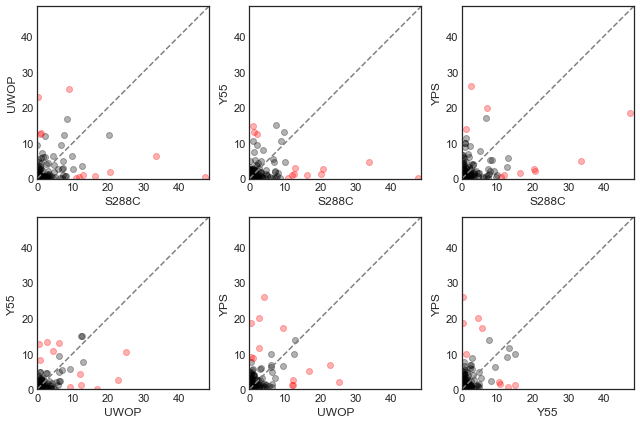

In [20]:
plot_overall(r)

Kegg modules
---

In [62]:
r = run_deviations(m, kegg)

In [63]:
z = get_deviating_complexes(r)
w = z.groupby(['complex', 'gene']).min()
w[w <= 0.05]['qvalue'].dropna().sort_values()

complex     gene   
sce_M00022  YGL148W    1.009962e-12
sce_M00102  YMR015C    2.924270e-12
sce_M00051  YOR303W    4.033754e-09
sce_M00048  YAR015W    1.011650e-08
sce_M00176  YJR137C    1.109515e-08
sce_M00074  YJR075W    8.972666e-07
sce_M00051  YJR109C    1.086494e-04
sce_M00433  YDL182W    3.325702e-04
sce_M00074  YDR245W    5.238237e-04
sce_M00428  YJL138C    5.916430e-04
sce_M00030  YDL182W    6.867479e-04
sce_M00023  YDR007W    7.173012e-04
sce_M00148  YKL148C    8.355179e-04
sce_M00020  YOR184W    8.820601e-04
sce_M00102  YML008C    1.046178e-03
sce_M00004  YNL241C    2.383023e-03
sce_M00023  YDR354W    2.497563e-03
sce_M00412  YPR173C    3.751903e-03
sce_M00692  YAL040C    3.751903e-03
sce_M00098  YCR068W    3.751903e-03
sce_M00018  YCR053W    4.903697e-03
sce_M00050  YLR432W    7.365050e-03
sce_M00307  YBR221C    1.039151e-02
sce_M00009  YLL041C    1.143480e-02
sce_M00307  YFL018C    1.261537e-02
sce_M00006  YNL241C    1.261537e-02
sce_M00148  YLL041C    1.413198e-02
sce_M001

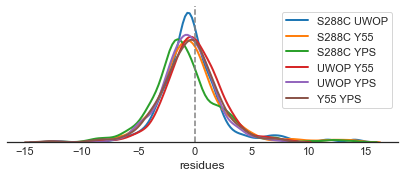

In [22]:
plot_residues(r)

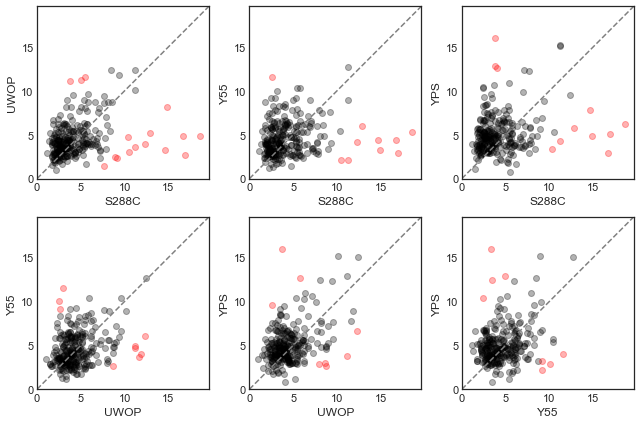

In [23]:
plot_overall(r)

In [24]:
r.groupby('complex').mad().sort_values(ascending=False).head()

complex
sce_M00048    3.507607
sce_M00102    3.146652
sce_M00022    2.437656
sce_M00176    2.426738
sce_M00074    2.372474
Name: distance, dtype: float64

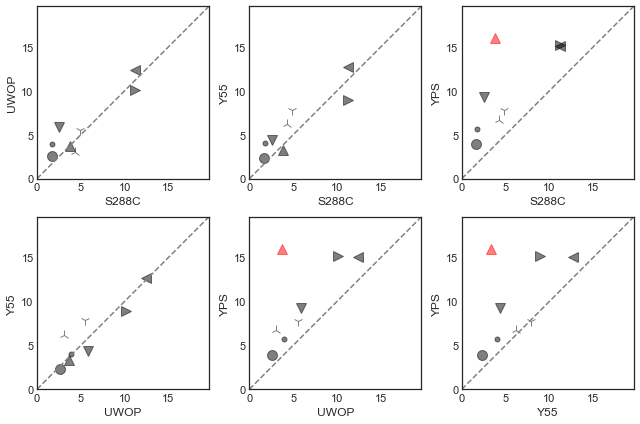

In [25]:
plot_single(r, 'sce_M00048')

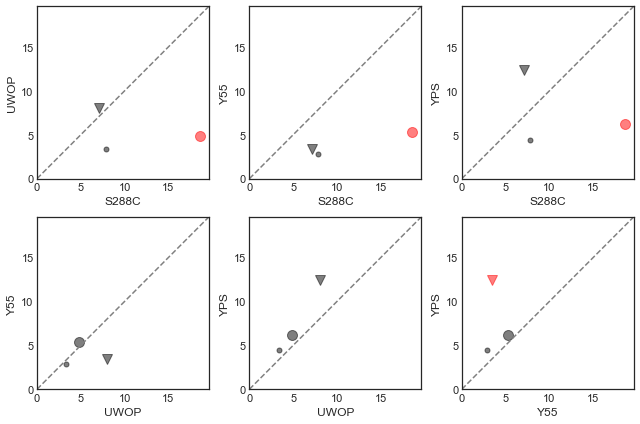

In [26]:
plot_single(r, 'sce_M00102')

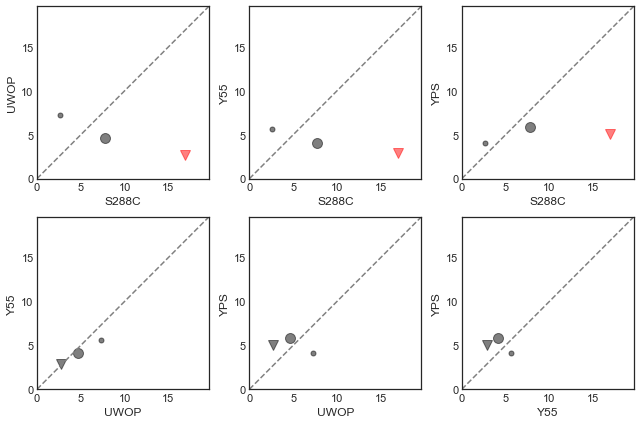

In [27]:
plot_single(r, 'sce_M00022')

In [28]:
r = run_deviations(m, kegg, significance=True)

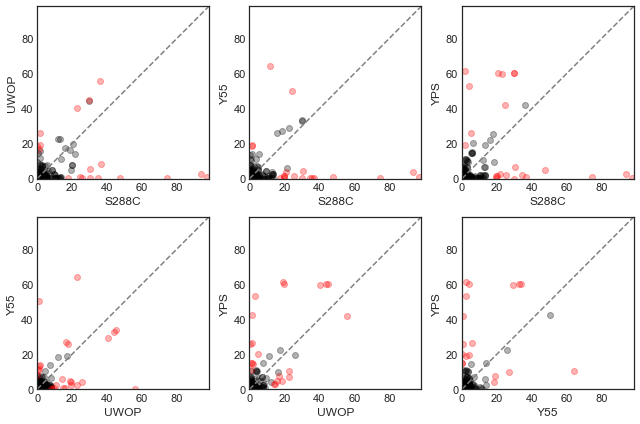

In [29]:
plot_overall(r)

String
---

In [64]:
r = run_deviations(m, string)

In [65]:
z = get_deviating_complexes(r)
w = z.groupby(['complex', 'gene']).min()
w[w <= 0.05]['qvalue'].dropna().sort_values()

complex  gene   
32       YLR312C    0.000550
10       YKL177W    0.001911
42       YER187W    0.003027
5        YFR018C    0.003176
26       YGL109W    0.013353
Name: qvalue, dtype: float64

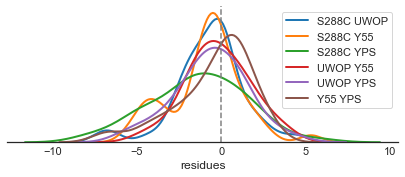

In [31]:
plot_residues(r)

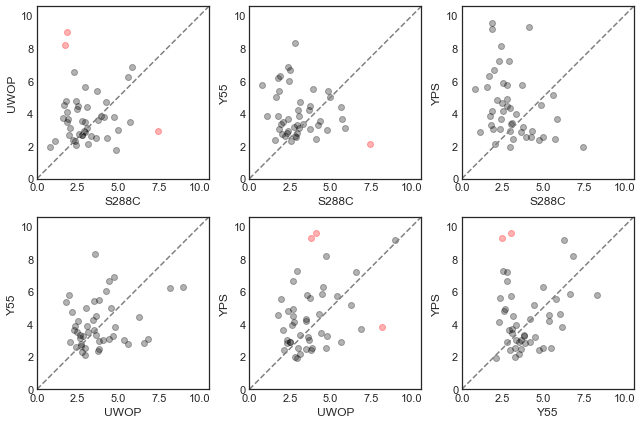

In [32]:
plot_overall(r)

In [33]:
r.groupby('complex').mad().sort_values(ascending=False).head()

complex
10    2.011098
32    2.001828
26    1.939594
42    1.641943
5     1.409469
Name: distance, dtype: float64

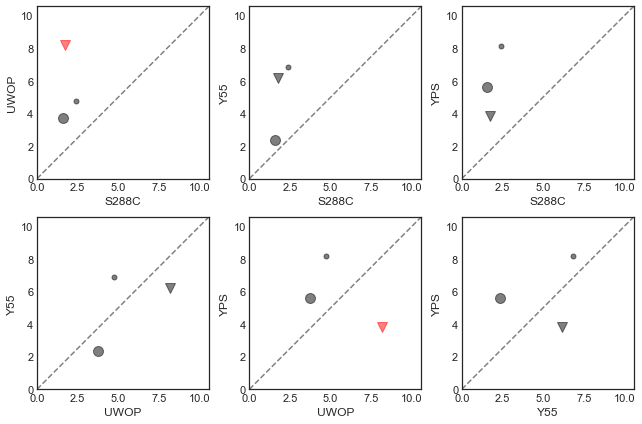

In [34]:
plot_single(r, '10')

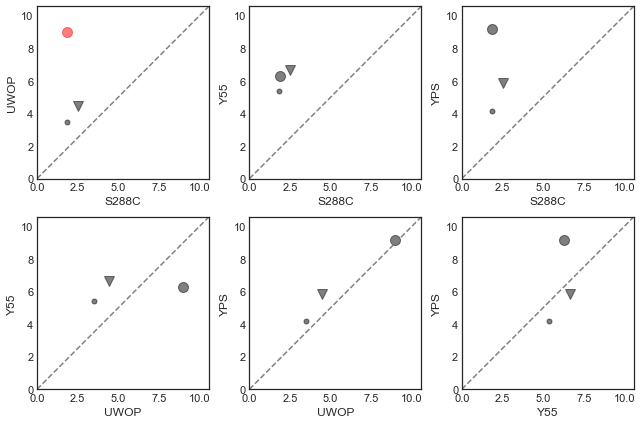

In [35]:
plot_single(r, '32')

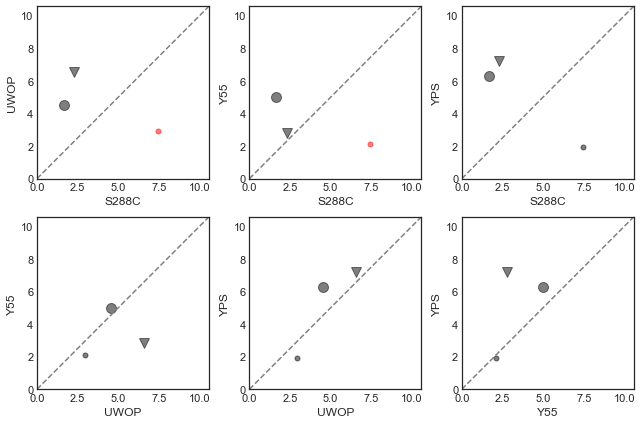

In [36]:
plot_single(r, '26')

In [37]:
r = run_deviations(m, string, significance=True)

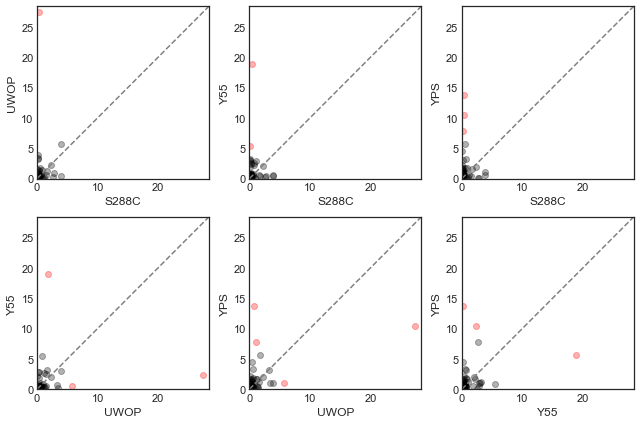

In [38]:
plot_overall(r)

GO terms
---

In [66]:
r = run_deviations(m, go, True)

In [67]:
z = get_deviating_complexes(r)
w = z.groupby(['complex', 'gene']).min()
w[w <= 0.05]['qvalue'].dropna().sort_values()

complex     gene     
GO:0008565  YBR171W      1.867212e-13
GO:0006413  YGR054W      1.114199e-09
GO:0008135  YGR054W      1.114199e-09
GO:0006887  YDR126W      1.829634e-09
GO:0006497  YDR126W      3.901665e-09
GO:0032543  YCR071C      3.929546e-08
GO:0004871  YJL095W      5.542131e-07
GO:0032543  YMR225C      1.437632e-06
GO:0008135  YER153C      1.437632e-06
GO:0004871  YFL026W      4.510264e-06
GO:0051604  YMR035W      5.950722e-06
GO:0032543  YER153C      6.596488e-06
GO:0005576  YLR286C      1.472030e-05
GO:0032543  YOR158W      2.536832e-05
GO:0006413  YPR129W      2.794575e-05
GO:0006360  YML121W      4.439455e-05
GO:0016050  YFL025C      6.054960e-05
GO:0006413  YJL138C      6.192984e-05
GO:0005085  YJR031C      8.588095e-05
GO:0008643  YHR094C      1.111971e-04
GO:0051082  YNL315C      1.207127e-04
GO:0006383  YML121W      1.642309e-04
GO:0000902  YLR313C      2.239018e-04
GO:0032182  YBL007C      2.549384e-04
GO:0006352  YGL043W      3.235571e-04
GO:0006353  YGL043W      3.2

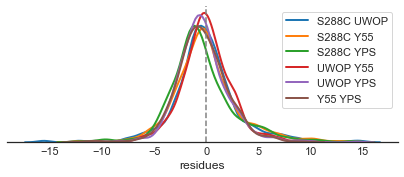

In [40]:
plot_residues(r)

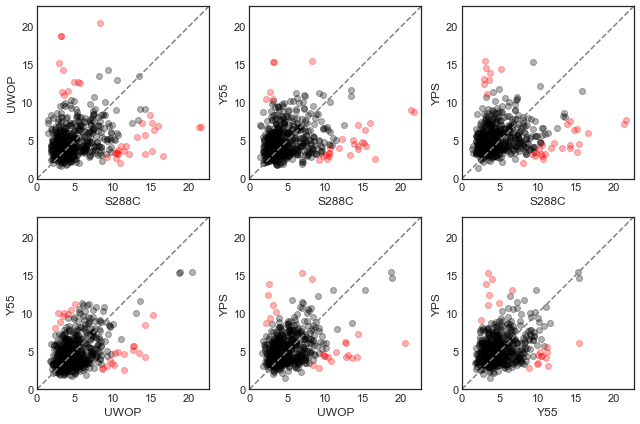

In [41]:
plot_overall(r)

In [42]:
r.groupby('complex').mad().sort_values(ascending=False).head()

complex
GO:0006413    2.483425
GO:0008135    2.379759
GO:0004871    2.360630
GO:0005085    2.015804
GO:0032543    2.015203
Name: distance, dtype: float64

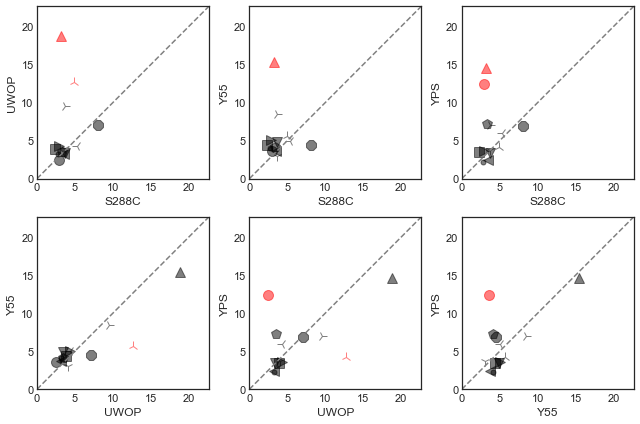

In [43]:
plot_single(r, 'GO:0006413')

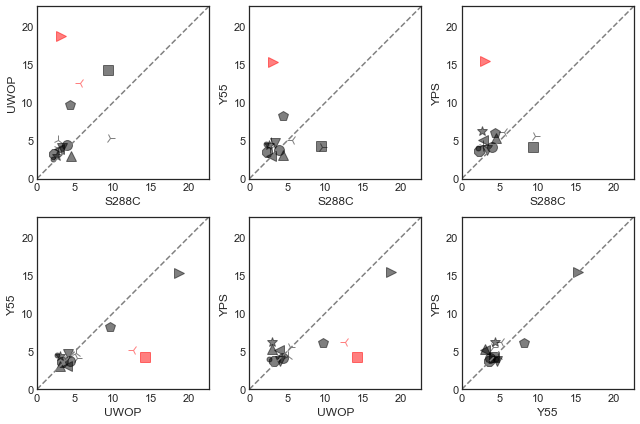

In [44]:
plot_single(r, 'GO:0008135')

In [45]:
r = run_deviations(m, go, True, True)

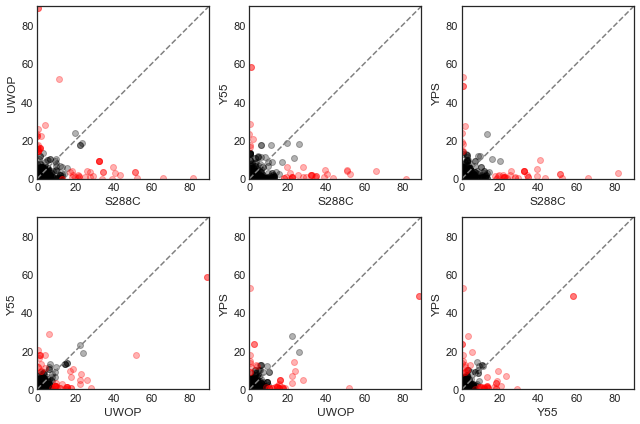

In [46]:
plot_overall(r)

<h5><a href="javascript:toggle()" target="_self">toggle source code</a></h5>